<a href="https://colab.research.google.com/github/groundivy-dev1/Test01/blob/main/ai_a_17_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyTorch의 size() 메서드

In [5]:
import torch
import torch.nn as nn

# 예제 데이터: [batch_size, channels, height, width]
data = torch.randn(8, 3, 4, 4)  # (batch_size=8, channels=3, height=4, width=4)

print(data.size(0))
print(data.size(1))
print(data.size(2))
print(data.size(3))

# Flatten Layer 구현
flattened = data.view(data.size(0), -1)  # 배치 차원 유지, 나머지 차원 flatten
print(flattened.shape)  # [8, 48]


8
3
4
4
torch.Size([8, 48])


PyTorch의 nn.Conv2d - 기본 사용법

In [7]:
import torch
import torch.nn as nn

# Conv2d 정의
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

# 임의 입력 데이터 (batch_size=8, channels=3, height=32, width=32)
x = torch.randn(8, 3, 32, 32)

# Conv2d 적용
output = conv(x)
print(output.shape)  # torch.Size([8, 16, 32, 32])


torch.Size([8, 16, 32, 32])


PyTorch의 nn.Conv2d - 다중 레이어

In [8]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Conv Layer
    nn.ReLU(),  # Activation
    nn.MaxPool2d(kernel_size=2, stride=2)  # Down-sampling
)

output = model(x)
print(output.shape)  # torch.Size([8, 16, 16, 16])


torch.Size([8, 16, 16, 16])


CNN에서 Flatten Layer - PyTorch의 view 메서드

In [10]:
import torch
import torch.nn as nn

# 예제 데이터: [batch_size, channels, height, width]
data = torch.randn(8, 3, 4, 4)  # (batch_size=8, channels=3, height=4, width=4)

# Flatten Layer 구현
flattened = data.view(data.size(0), -1)  # 배치 차원 유지, 나머지 차원 flatten
print(flattened.shape)  # [8, 48]


torch.Size([8, 48])


CNN에서 Flatten Layer - 3D 텐서를 12차원 벡터로 변환 예제

In [12]:
data = torch.randn(10, 2, 3, 2)  # [batch_size=10, channels=2, height=3, width=2]

# Flatten
flattened = data.view(data.size(0), -1)  # batch_size 유지, 나머지 flatten
print(flattened.shape)  # [10, 12]


torch.Size([10, 12])


CNN에서 Flatten Layer - Flatten Layer를 위한 PyTorch의 nn.Flatten 사용

In [15]:

flatten = nn.Flatten()  # Flatten Layer
data = torch.randn(8, 3, 4, 4)
flattened = flatten(data)
print(flattened.shape)  # [8, 48]

data = torch.randn(8, 3, 5, 5)
flattened = flatten(data)
print(flattened.shape)  # [8, 48]

torch.Size([8, 48])
torch.Size([8, 75])


CIFAR10 예제

In [2]:
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"using PyTorch version: {torch.__version__}, Device: {DEVICE}")

using PyTorch version: 2.5.1+cu121, Device: cpu


In [4]:
train_dataset = datasets.CIFAR10(root='CIFAR10_data/', train=True, download=True,
                               transform=transforms.ToTensor())

test_dataset = datasets.CIFAR10(root='CIFAR10_data/', train=False, download=True,
                              transform=transforms.ToTensor())

100%|██████████| 170M/170M [00:03<00:00, 49.5MB/s]


Extracting CIFAR10_data/cifar-10-python.tar.gz to CIFAR10_data/
Files already downloaded and verified


In [19]:
print(len(train_dataset))

train_dataset_size = int(len(train_dataset) * 0.85)
validation_dataset_size = int(len(train_dataset) * 0.15)

train_dataset, validation_dataset = random_split(train_dataset, [train_dataset_size, validation_dataset_size])

print(len(train_dataset), len(validation_dataset), len(test_dataset))


50000
42500 7500 10000


In [20]:
BATCH_SIZE = 64

train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [21]:
class MyCNNModel(nn.Module):

    def __init__(self):

        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(8 * 8 * 64, 128)
        self.fc2 = nn.Linear(128, 10)

        self.dropout25 = nn.Dropout(p=0.25)
        self.dropout50 = nn.Dropout(p=0.5)

    def forward(self, data):

        data = self.conv1(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = self.conv2(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = data.view(-1, 8 * 8 * 64)

        data = self.fc1(data)
        data = torch.relu(data)
        data = self.dropout50(data)

        logits = self.fc2(data)

        return logits

In [22]:
model = MyCNNModel().to(DEVICE)

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)


In [23]:
def model_train(dataloader, model, loss_function, optimizer):

    model.train()

    train_loss_sum = train_correct = train_total = 0

    total_train_batch = len(dataloader)

    for images, labels in dataloader:

        x_train = images.to(DEVICE)
        y_train = labels.to(DEVICE)

        outputs = model(x_train)
        loss = loss_function(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

        train_total += y_train.size(0)
        train_correct += ((torch.argmax(outputs, 1)==y_train)).sum().item()

    train_avg_loss = train_loss_sum / total_train_batch
    train_avg_accuracy = 100*train_correct / train_total

    return (train_avg_loss, train_avg_accuracy)

In [24]:
def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval()

    with torch.no_grad():

        val_loss_sum = val_correct = val_total = 0

        total_val_batch = len(dataloader)

        for images, labels in dataloader:

            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()

            val_total += y_val.size(0)
            val_correct += ((torch.argmax(outputs, 1)==y_val)).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch
        val_avg_accuracy = 100*val_correct / val_total

    return (val_avg_loss, val_avg_accuracy)

In [25]:
def model_test(dataloader, model):

    model.eval()

    with torch.no_grad():

        test_loss_sum = test_correct = test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader:

            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test)
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item()

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('accuracy:', test_avg_accuracy)
        print('loss:', test_avg_loss)

In [26]:
from datetime import datetime

train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 100

for epoch in range(EPOCHS):

    #==============  model train  ================
    train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_function, optimizer)

    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)
    #=============================================

    #============  model evaluation  ==============
    val_avg_loss, val_avg_accuracy = model_evaluate(validation_dataset_loader, model, loss_function, optimizer)

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)
    #============  model evaluation  ==============

    print('epoch:', '%02d' % (epoch + 1),
          'train loss =', '{:.3f}'.format(train_avg_loss), 'train acc =', '{:.3f}'.format(train_avg_accuracy),
          'val loss =', '{:.3f}'.format(val_avg_loss), 'val acc =', '{:.3f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

epoch: 01 train loss = 1.712 train acc = 36.941 val loss = 1.389 val acc = 51.080
epoch: 02 train loss = 1.419 train acc = 48.435 val loss = 1.234 val acc = 56.960
epoch: 03 train loss = 1.305 train acc = 52.993 val loss = 1.140 val acc = 60.440
epoch: 04 train loss = 1.228 train acc = 55.776 val loss = 1.092 val acc = 61.707
epoch: 05 train loss = 1.174 train acc = 57.958 val loss = 1.023 val acc = 64.280
epoch: 06 train loss = 1.124 train acc = 60.353 val loss = 1.011 val acc = 64.240
epoch: 07 train loss = 1.083 train acc = 61.421 val loss = 0.965 val acc = 66.067
epoch: 08 train loss = 1.054 train acc = 62.656 val loss = 0.952 val acc = 66.760
epoch: 09 train loss = 1.025 train acc = 63.513 val loss = 0.957 val acc = 66.427
epoch: 10 train loss = 1.001 train acc = 64.480 val loss = 0.882 val acc = 68.920
epoch: 11 train loss = 0.978 train acc = 65.096 val loss = 0.875 val acc = 69.387
epoch: 12 train loss = 0.961 train acc = 65.748 val loss = 0.885 val acc = 69.147
epoch: 13 train 

In [27]:
# test dataset 으로 정확도 및 오차 테스트

model_test(test_dataset_loader, model)

accuracy: 74.96
loss: 0.7669654302536302


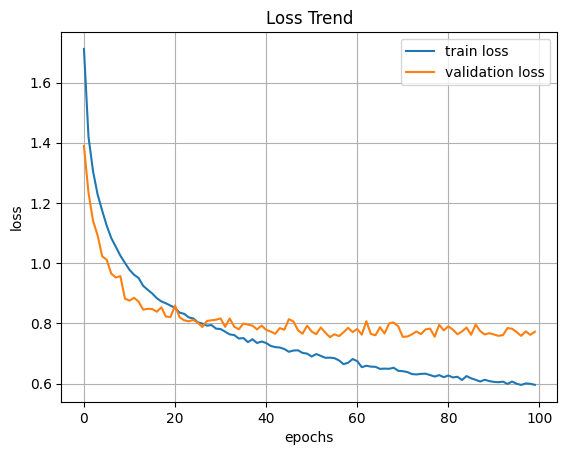

In [28]:
import matplotlib.pyplot as plt

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')

plt.legend()

plt.show()


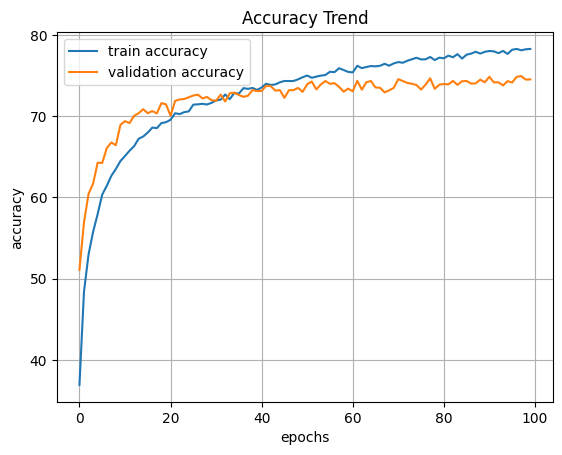

In [29]:
import matplotlib.pyplot as plt

plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')

plt.legend()

plt.show()

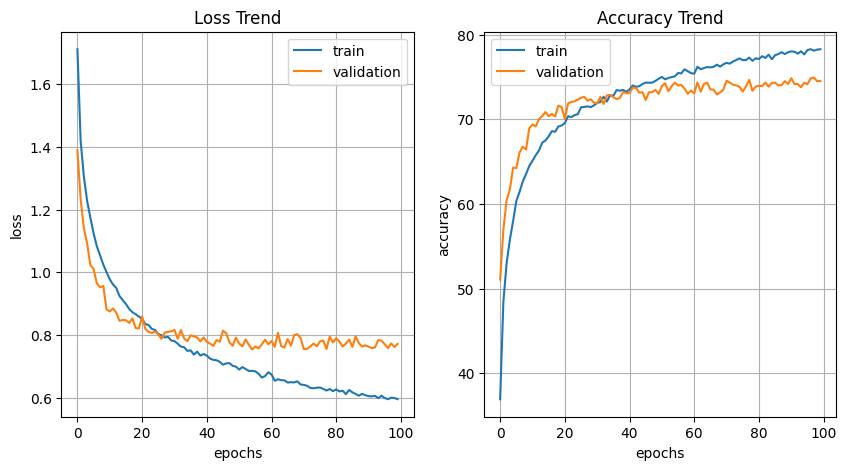

In [30]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()

In [ ]:
best_val_accuracy = 0.0

for epoch in range(EPOCHS):
    # 훈련 및 검증 코드...

    # 모델 성능이 개선되었을 경우 저장
    if val_avg_accuracy > best_val_accuracy:
        best_val_accuracy = val_avg_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Epoch {epoch+1}: Model saved with accuracy {best_val_accuracy:.3f}")
